In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import imblearn
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.tree import _tree, DecisionTreeClassifier
from IPython.display import display, HTML
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, plot_roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_auc_score

In [27]:
# Self defined functions
from feature_selection import feature_selection
from splitter import splitter

In [3]:
# Feature selection
X, y = feature_selection("/content/Dog_1.csv", verbose=False, further=True)

Number of Observation(raw): 8064
Number of features(raw): 449
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [4]:
# Train Test Split
X_train, X_test, y_train, y_test = splitter(X, y, 0.2, scaler=True)

In [15]:
# The class distribution is very imbalanced
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 2044, 1.0: 106}


In [20]:
oversample = imblearn.over_sampling.SMOTE()
# Over sample the minority class
X_train, y_train = oversample.fit_resample(X_train, y_train)
# Check the new class numbers
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 2044, 1.0: 2044}


In [22]:
# Unfortunately we have to rescale the training data again
train_scaler = preprocessing.StandardScaler().fit(X_train)
X_train = train_scaler.transform(X_train)

In [28]:
# Utility function to visualize the outputs of PCA and t-SNE

def grouping_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [31]:
# Before the tSNE first use the PCA
time_start = time.time()

pca_20 = PCA(n_components=20)
pca_result_20 = pca_20.fit_transform(X_train)

print("PCA with 20 components done! Time elapsed: {} seconds".format(time.time() - time_start))
print("cuculative variance exlained by 20 principle components: {}".format(np.sum(pca_20.explained_variance_ratio_)))

PCA with 20 components done! Time elapsed: 0.08838748931884766 seconds
cuculative variance exlained by 20 principle components: 0.8709827586290103


In [32]:
time_start = time.time()

pca_20_tsne = TSNE(random_state=2021).fit_transform(pca_result_20)
print("t-SNE done! Time elapsed: {} seconds".format(time.time()-time_start))

t-SNE done! Time elapsed: 27.27975082397461 seconds


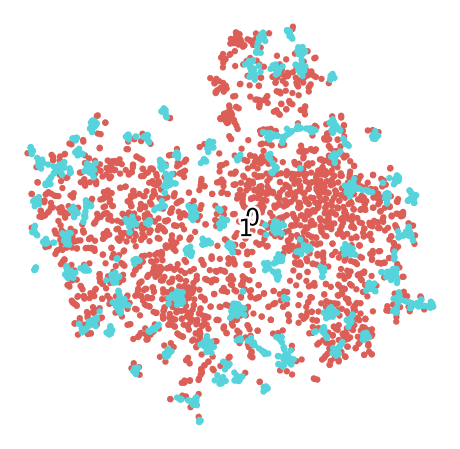

In [38]:
# Visualize the tSNE
grouping_scatter(pca_20_tsne, y_train)
plt.show()

In [47]:
# Logistic Regression
clf = LogisticRegression(random_state=2021).fit(X_train, y_train)
train_predict = clf.predict(X_train)
test_predict = clf.predict(X_test)
print("Training Performance")
print(classification_report(y_train, train_predict, target_names=["Normal", "Siezure"]))
print("\n")
print("Test Performance")
print(classification_report(y_test, test_predict, target_names=["Normal", "Siezure"]))

Training Performance
              precision    recall  f1-score   support

      Normal       0.84      0.77      0.81      2044
     Siezure       0.79      0.86      0.82      2044

    accuracy                           0.81      4088
   macro avg       0.82      0.81      0.81      4088
weighted avg       0.82      0.81      0.81      4088



Test Performance
              precision    recall  f1-score   support

      Normal       1.00      0.49      0.66       516
     Siezure       0.07      0.95      0.14        22

    accuracy                           0.51       538
   macro avg       0.54      0.72      0.40       538
weighted avg       0.96      0.51      0.64       538



In [76]:
y_hat = clf.predict_proba(X_test)[:, 1]
# Calculate the ROC Curves
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
# Get the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# Locate the index
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.718953, G-Mean=0.793


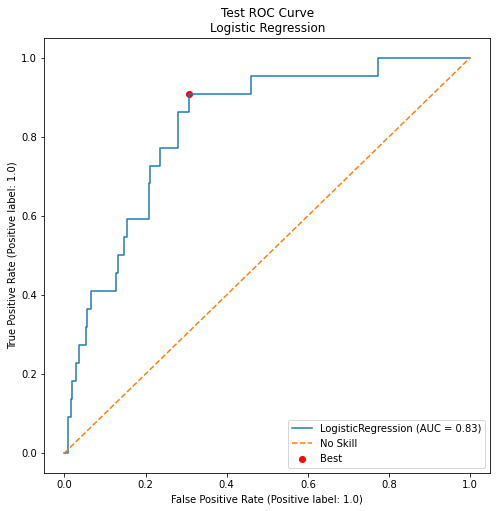

In [82]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_roc_curve(clf, X_test, y_test, ax=ax)
ax.plot([0,1], [0,1], linestyle='--', label='No Skill')
ax.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
ax.set_title("Test ROC Curve\nLogistic Regression")
ax.legend(loc='lower right')
plt.show()

In [83]:
print("Test Performance")
print(classification_report(y_test, (clf.predict_proba(X_test)[:,1] >= thresholds[ix]).astype(bool), target_names=["Normal", "Siezure"]))

Test Performance
              precision    recall  f1-score   support

      Normal       0.99      0.69      0.82       516
     Siezure       0.11      0.91      0.20        22

    accuracy                           0.70       538
   macro avg       0.55      0.80      0.51       538
weighted avg       0.96      0.70      0.79       538

